In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

%matplotlib inline

In [2]:
riskFactors = pd.read_excel("Risk_Factors.xlsx")
industryPort = pd.read_excel("Industry_Portfolios.xlsx")

/Users/gab/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
riskFactors.head()

,Date,Rf,Rm-Rf,SMB,HML
0,200401,0.07,2.15,2.67,1.55
1,200402,0.06,1.40,-1.17,0.45
2,200403,0.09,-1.32,1.84,0.07
3,200404,0.08,-1.83,-2.59,-1.67
4,200405,0.06,1.17,-0.10,-0.33


In [4]:
industryPort.head()

,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,200401,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88
1,200402,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16
2,200403,-0.09,-1.15,-0.27,-0.13,-2.55,-2.07,0.29,-3.96,1.13,-0.63
3,200404,1.42,2.30,-0.17,2.52,-4.91,-0.48,-2.70,3.54,-3.55,-3.76
4,200405,-1.89,-1.64,1.61,0.39,4.85,-2.95,0.30,-0.42,1.28,1.86


In [5]:
#Minus risk-free rate for all portfolios in all months
industryPort.loc[:,'NoDur':] = industryPort.loc[:,'NoDur':].apply(lambda x: x - riskFactors.loc[:,'Rf'] )

In [6]:
#Creating empty dataframe with the 10 portfolios as index
tempIndex = industryPort.columns[1:]
portMetric = pd.DataFrame(index = tempIndex)

#Calculating Jensen Alpha
capmList = []
x = riskFactors['Rm-Rf']
x = sm.add_constant(x)
for temp in industryPort.columns:
    if ( temp != 'Date'):
        y  = industryPort[str(temp)]      
        result = sm.OLS(y, x).fit()
        tempIntercept = result.params['const']
        tempSlope = result.params['Rm-Rf']
        capmList.append([tempIntercept,tempSlope])

capmDf = pd.DataFrame(data = capmList, columns = ['Alpha','Beta'],index = tempIndex)
portMetric['JensenAlpha'] = capmDf.loc[:,'Alpha']

#Treynor ratio
portMetric['TreynorRatio'] = industryPort.loc[:,'NoDur':].mean() / capmDf.loc[:,'Beta']

#Calculating Sharpe Ratio
sharpeRatio = industryPort.loc[:,'NoDur':].mean() / industryPort.loc[:,'NoDur':].std()
portMetric['SharpeRatio'] = sharpeRatio

#Calculating Fama-French 3 Factor Alpha
ffList = []
x = riskFactors[['Rm-Rf','SMB','HML']]
x = sm.add_constant(x)
for temp in industryPort.columns:
    if ( temp != 'Date'):
        y  = industryPort[str(temp)]      
        result = sm.OLS(y, x).fit()
        tempIntercept = result.params['const']
        tempSlope = result.params['Rm-Rf']
        ffList.append([tempIntercept,tempSlope])
        predictions= result.summary()

ffDf = pd.DataFrame(data = ffList, columns = ['Alpha','Beta'],index = tempIndex)
portMetric['ThreeFactorAlpha'] = ffDf.loc[:,'Alpha']

#Calculating Sortino Ratio
minDiffDf = industryPort.copy()
minDiffDf.loc[:,'NoDur':] = np.where(minDiffDf.loc[:,'NoDur':] < 0,minDiffDf.loc[:,'NoDur':]**2,0 )
sampleSemiVar = minDiffDf.loc[:,'NoDur':].sum() / 120
portMetric['SortinoRatio'] = industryPort.loc[:,'NoDur':].mean() / np.sqrt(sampleSemiVar)


/Users/gab/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Q: Create a table showing the performance metrics for the ten industry portfolios.**

In [7]:
portMetric

,JensenAlpha,TreynorRatio,SharpeRatio,ThreeFactorAlpha,SortinoRatio
NoDur,0.369717,1.186372,0.231099,0.386704,0.350804
Durbl,-0.417903,0.367463,0.072356,-0.474342,0.111967
Manuf,0.160494,0.758251,0.166616,0.153285,0.241260
Enrgy,0.504485,1.143330,0.181708,0.523007,0.273612
HiTec,-0.064024,0.564295,0.118552,-0.065979,0.170620
Telcm,0.194348,0.836363,0.169064,0.200724,0.244940
Shops,0.274093,0.951258,0.191753,0.255941,0.293032
Hlth,0.236968,0.971435,0.172529,0.257472,0.270294
Utils,0.446523,1.452334,0.210948,0.474411,0.290044
Other,-0.387508,0.299781,0.064693,-0.404412,0.087351


**Sharpe ratio**

<AxesSubplot:title={'center':'Sharpe Ratio'}>

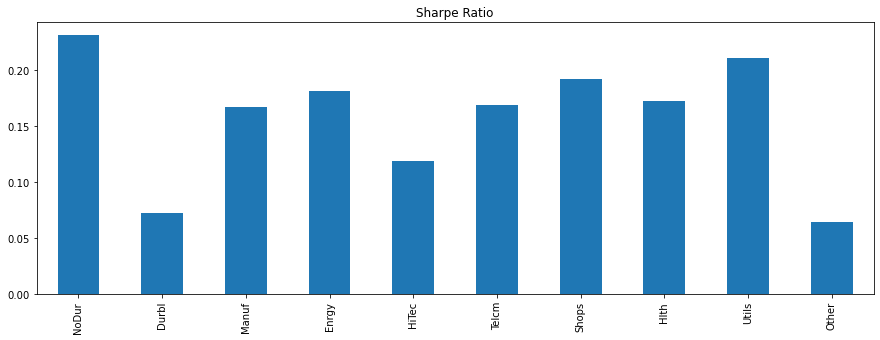

In [8]:
portMetric['SharpeRatio'].plot(kind = 'bar', title = 'Sharpe Ratio', figsize = (15,5))

<u>Economic Signifiance</u><br>
Sharpe ratio measure the additional excess return per unit of risk taken in the portfolio

**Sortino ratio**

<AxesSubplot:title={'center':'Sortino Ratio'}>

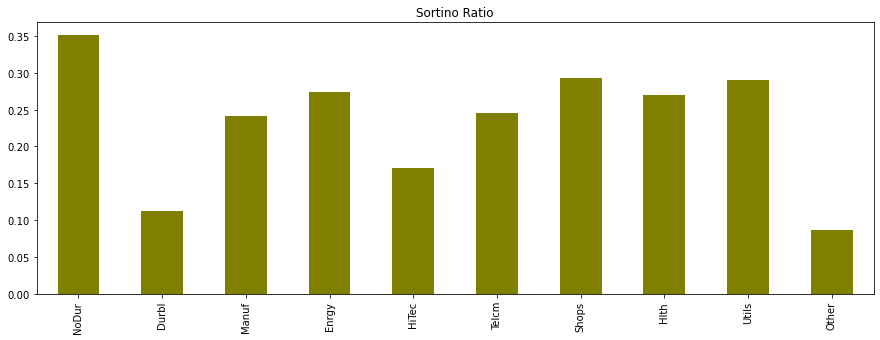

In [9]:
portMetric['SortinoRatio'].plot(kind = 'bar', title = 'Sortino Ratio', figsize = (15,5), color = 'olive')

<u>Economic Signifiance</u><br>
Sortino ratio measures the additional excess return per additional unit of down-side risk taken by the investor. This ratio also provides a way to distinguish asymmetric and non-normal return

**Treynor ratio**

<AxesSubplot:title={'center':'Treynor Ratio'}>

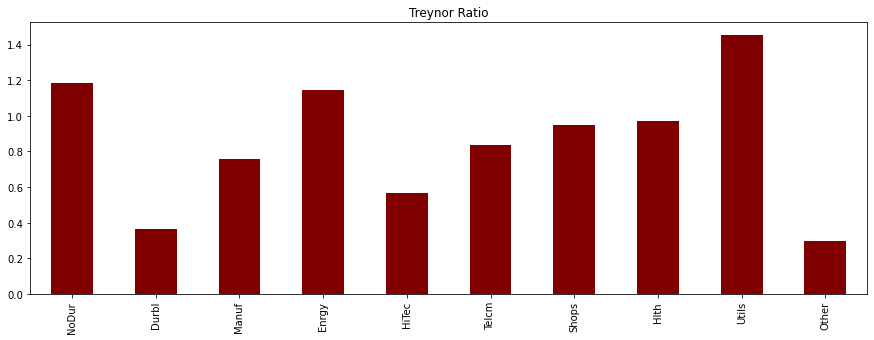

In [10]:
portMetric['TreynorRatio'].plot(kind = 'bar', title = 'Treynor Ratio', figsize = (15,5), color = 'maroon')

<u>Economic Signifiance</u><br>
Treynor ratio measure the additional excess return per unit of systematic/market risk taken in the portfolio

**Jensen's α (alpha)**

<AxesSubplot:title={'center':'Jensen Alpha'}>

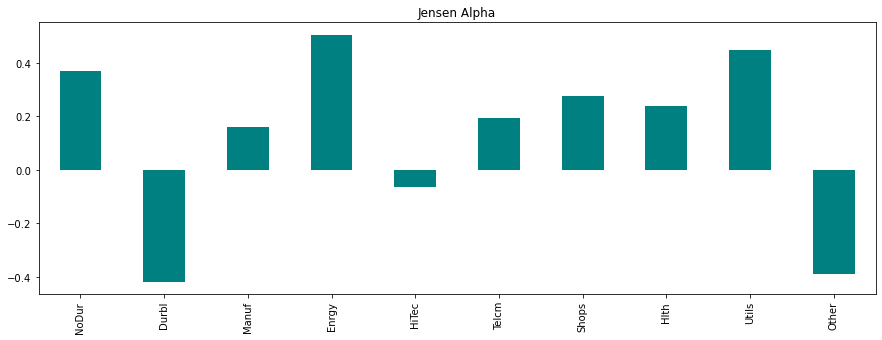

In [11]:
portMetric['JensenAlpha'].plot(kind = 'bar', title = 'Jensen Alpha', figsize = (15,5), color = 'teal')

<u>Economic Signifiance</u><br>
For a passive portfolio, the jensen alpha represents pricing error relative to CAPM (This error could be due to risks that are not identified with beta or the assets being overpriced or underpriced. On the other hand, for an active portfolio, the jensen alpha represents abnormal mean return after accounting for exposure to market risks - serving as a indicator to identify a portfolio manager's ability to identify overpriced or underpriced assets

**Three-Factor α (alpha)**

<AxesSubplot:title={'center':'Three Factor Alpha'}>

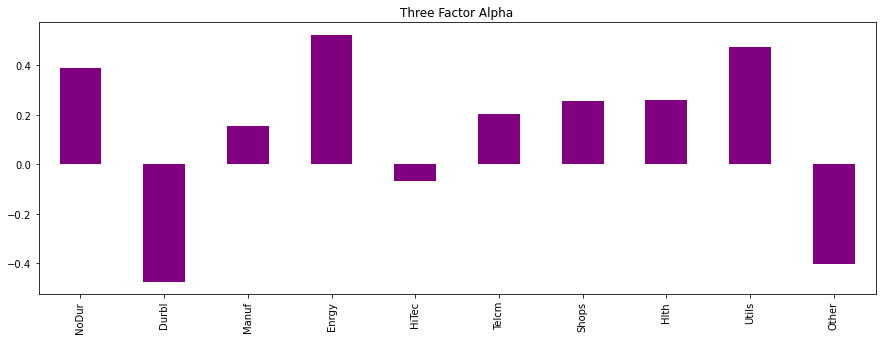

In [12]:
portMetric['ThreeFactorAlpha'].plot(kind = 'bar', title = 'Three Factor Alpha', figsize = (15,5), color = 'purple')

<u>Economic Signifiance</u><br>
For a passive portfolio, the three-factor alpha represents pricing error relative to Fama-French three factor model. On the other hand, for an active portfolio, the three-factor alpha represents abnormal mean return after accounting for exposure to market risks,size risk and value risk - serving as a indicator to identify a portfolio manager's ability to identify overpriced or underpriced assets